In [1]:
# import data vis modules
import matplotlib.pyplot as plt
from matplotlib import ticker as mtick
import seaborn as sns

# import data management modules
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np

# import stats modules
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats


# read in json file 
hr = pd.read_json('..\data\output\hr_df.json')

# Chi-Square Analysis and Logistic Regression
The chi-square test of association is a descriptive statistic used to measure the significance of the association between categorical variables. It is non-parametric and is not dependent on a specific probability distribution. Data needs to be formatted as a contingency table, also known as a crosstab, to calculate the chi-square statistic. Binary logistic regression is a predictive modeling technique based on the binomial distribution. The model’s dependent variable is categorical and can only take on two values. Although the two techniques have different assumptions, they are closely related. I'll use fictionalized promotion data from the HR department of a multinational corporation to demonstrate using a chi-square test of assocation and logistic regression to calculate the odds of promotion based on gender.  I'll also explain when to use logistic regression instead of a chi-square test.  

## Chi-Square Analysis
The chi-square analysis compares the overall promotion rate, or marginal probability, to the female and male promotion rate - the joint probability. The expected values for female and male promotion would be very close to the marginal distribution if there isn't an association based on gender. The chi-square statistic is the sum of the difference between the observed and expected values for each cell in the contingency table. This value gets compared to the chi-square distribution to see if it's statistically significant. The department promotion rate chart below shows that 5.62% of employees received a promotion; this is the marginal probability. The joint probability is 5.77% for female promotions; it's 5.52% for males.

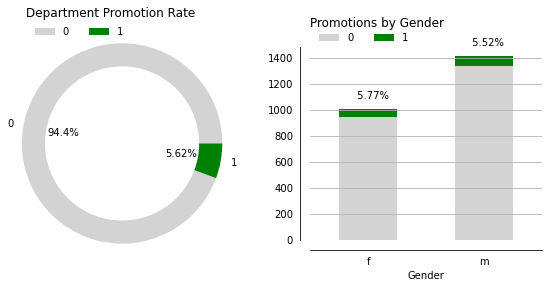

### Chi-Square Assumptions
1. Data is formatted as counts
2. Observations are mutually exclusive and can't be counted in more than one cell
3. Observations are independent
4. At least 80% of the cells must have an expected value of at least 5; no cells should have a value less than 1

The first step in performing the chi-square test of association is to create a contingency table to format the data as counts. You can pivot your data or build a table from the raw data using the statsmodels Table class.

``` python

# create a contingency table 
tab = sm.stats.Table.from_data(hr[['gender', 'is_promoted']])

# display table and counts
tab.table_orig

```
| gender   |    0 |   1 |
|:---------|-----:|----:|
| f        |  948 |  58 |
| m        | 1334 |  78 |

The fittedvalues attribute of the contingency table displays the expected values. All cells are more than 5; we can run the test.

``` python
# display fitted values
tab.fittedvalues
```

| gender   |        0 |       1 |
|:---------|---------:|--------:|
| f        |  949.418 | 56.5823 |
| m        | 1332.58  | 79.4177 |

Calling the test_nominal_association() method returns the degrees of freedom, p-value, and chi-square statistic. With a p-value of 0.8 there is no association between gender and promotion.

```python
# results of the test of association
assoc_res = tab.test_nominal_association()
df = assoc_res.df # degrees of freedom
pval = assoc_res.pvalue # p-value
stat = assoc_res.statistic # chi-square statistic
```

We can validate these results using the standardized residuals; if the standardized residuals are less than +/-2 there is no association for a 2x2 table.

| gender   |         0 |         1 |
|:---------|----------:|----------:|
| f        | -0.253878 |  0.253878 |
| m        |  0.253878 | -0.253878 |

The ability to calculate the odds of an event is another useful feature of contigency tables. The odds of a woman getting promoted is 0.061; it is 0.058 for a man. The odds ratio is calculated by dividing 2 odds. The odds ratio for female vs male promotion is 1.046. An odds ratio of 1 means that event is equally likely to occur in both groups.

```python
# odds of a woman getting promoted is 0.061
odds_woman = tab.table_orig.loc['f',1] / tab.table_orig.loc['f', 0]

# odds of a man getting promoted is 0.058
odds_man = tab.table_orig.loc['m',1] / tab.table_orig.loc['m',0]

# odds of a woman getting promoted vs a man is an odds ratio of 1.046
odds_ratio_fem = odds_woman/odds_man

```

## Logistic Regression

Binary logistic regression is an extension of linear regression used when the dependent variable is categorical. Linear regression predictions can range from -$\infty$ to +$\infty$, but logistic regression predictions can only go from 0 to 1. We can use the output of a logistic regression model to calculate the odds of an event occurring. For example, we can use our dataset to determine the odds of a female employee getting promoted.


### Binary Logistic Regression Assumptions
1. The dependent variable is binary - promoted vs not promoted
2. Observations are independent
3. Linearity in the coefficients
4. No multicollinearity
5. Large sample size. Rule of thumb is 10 observations of the least frequent outcome


First, I'll build the logistic regression model with males as the baseline gender. The regression model outputs a summary table that includes the number of records and a description of the model fit. The second table presents the model coefficients, p-values, z-scores, and confidence intervals.


``` python

# build the logistic regression model with male as the baseline gender
mod = smf.glm('is_promoted ~ C(gender, Treatment("m"))', data = hr, family = sm.families.Binomial())

# fit the model
res = mod.fit()

# get the model summary
summary = res.summary()

# save model output as markdown
print(pd.read_html(summary.tables[0].as_html(), header= None, index_col=0)[0].to_markdown())

print(pd.read_html(summary.tables[1].as_html(), header= None, index_col=0)[0].to_markdown())


```

|                  |                  |                     |             |
|:-----------------|:-----------------|:--------------------|------------:|
| Dep. Variable:   | is_promoted      | No. Observations:   | 2418        |
| Model:           | GLM              | Df Residuals:       | 2416        |
| Model Family:    | Binomial         | Df Model:           |    1        |
| Link Function:   | logit            | Scale:              |    1        |
| Method:          | IRLS             | Log-Likelihood:     | -523.48     |
| Date:            | Sat, 01 Jan 2022 | Deviance:           | 1047        |
| Time:            | 16:02:33         | Pearson chi2:       | 2420        |
| No. Iterations:  | 6                | Pseudo R-squ. (CS): |    2.66e-05 |
| Covariance Type: | nonrobust        | nan                 |  nan        |


|                                |         |         |         |       |        |        |
|:-------------------------------|:--------|:--------|:--------|:------|:-------|:-------|
| nan                            | coef    | std err | z       | P>|z| | [0.025 | 0.975] |
| Intercept                      | -2.8392 | 0.116   | -24.373 | 0.000 | -3.068 | -2.611 |
| C(gender, Treatment("m"))[T.f] | 0.0453  | 0.179   | 0.254   | 0.800 | -0.305 | 0.395  |

### Understanding Logistic Regression Parameters

Since I set male employees as the baseline, taking the exponent of the intercept calculates the odds of a male employee getting promoted. $e^{-2.8392}$ returns 0.058. Taking the exponent of the sum of the parameters, $e^{-2.8392 + 0.0453}$, calculates the odds of a female employee getting promoted as 0.061. The odds ratio can be derived by taking the exponent of the indicator variable for female employees, $e^{0.0453}$, which returns 1.046. These values are consistent with what was quantified from the contingency table. 

### Evaluating Model Fit

The Wald statistic can be used to evaluate the model since there's only one predictor. The **Wald Statistic** calculated as $Z=\frac{{\widehat{\beta}}}{SE}$ is included in the model summary and can also be calculated from the model attributes using  ``` python res.wald_test_terms() ``` $Z^{2}$ approximates a chi-square distribution with df=1. The null hypothesis is that $\beta = 0$. With p > 0.05, we fail to reject the null hypothesis that gender has no effect on promotion.

|                           |   statistic |      pvalue |   df_constraint |
|:--------------------------|------------:|------------:|----------------:|
| Intercept                 | 594.041     | 3.3109e-131 |               1 |
| C(gender, Treatment("m")) |   0.0644448 | 0.799604    |               1 |

The **Likelihood-ratio test** is an alternative method of assessing model fit by comparing the intercept only model to the model with gender as a variable. The null hypothesis is that the gender parameter is equal to 0. The likelihood ratio is 0.1 with a  p-value of 0.752. 

```python
# likelihood statistic is the difference in the deviances 
llr=round(res.null_deviance-res.deviance,res.df_model)

# calculate the p-value from the chi-square distribution
p_val=round(1 - stats.chi2.cdf(llr, 1),5)


```

###  Advantages of Logistic Regression
An advantage of logistic regression is the ability to include both categorical and continuous variables in the analysis. When it comes to the topic of promotions, the literature indicates that there are several confounding variables that should be included. For example, [McKinsey's 2021 report on women in the workplace](https://wiw-report.s3.amazonaws.com/Women_in_the_Workplace_2021.pdf) indicates that early career promotion inequities based on gender exist so we should consider job level as a potential confounder.

In [2]:
{
    "tags": [
        "hide-cell"
    ]
}

{'tags': ['hide-cell']}

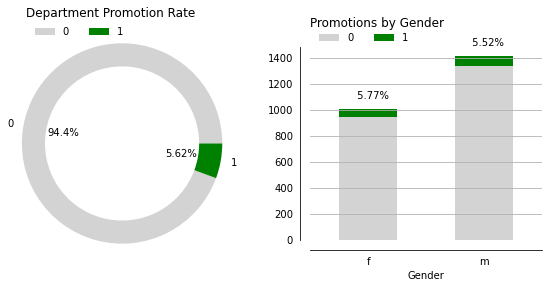

In [3]:
fig, ax = plt.subplots(1,2, figsize = (8,4))

hr.is_promoted.value_counts(normalize = True).plot.pie(radius = 1.3, wedgeprops = {'width': 0.3}, 
                                                       colors = ['lightgray','green'],
                                                      autopct = lambda p:f'{p:0.3}%',
                                                      ax = ax[0])

ax[0].set_ylabel('')
ax[0].set_title('Department Promotion Rate', pad = 30, loc = 'left')
ax[0].legend(frameon = False, ncol = 2, loc = 'upper left', bbox_to_anchor = (0,1.15))




# plot bar chart
(hr.pivot_table(index = 'gender', columns = 'is_promoted', 
               values = 'employee_id', aggfunc = 'count')
 .plot.bar(stacked = True, rot = 0, color = {0:'lightgray', 1:'green'}, ax = ax[1]))
ax[1].set_title('Promotions by Gender', pad = 20, loc = 'left')
ax[1].legend(frameon = False, ncol = 2, loc = 'upper left', bbox_to_anchor = (0,1.12))
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_position(('outward',10))
ax[1].spines['bottom'].set_position(('outward',10))
ax[1].tick_params(left = False, bottom = False)
ax[1].set_xlabel('Gender')
ax[1].grid(axis='y')


for p in ax[1].containers[-1].patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x()
    y = p.get_y()

    total = height + y
    
    pct_promoted = 0 if height == 0 else height/total

    ax[1].annotate(f'{pct_promoted: 0.2%}', xy= (x, total), xytext = (width*64,10),
               textcoords = 'offset points', ha = 'center')
    
plt.tight_layout()